# Getting all the Proceedings Data
This script might need to be run multiple times. Crawling ACM is not a simple task. The cleaning of the lower part of the file works directly for MobielHCI 2005 to 2024; however, for other years, the helper maps in `utils` may need to be amended.

Author: Sven Mayer (info@sven-mayer.com)

LICENSE: GPL-3.0 license 

In [ ]:
import pandas as pd

import time
import tqdm
import glob
from selenium import webdriver
from selenium.webdriver.common.by import By

In [200]:
def setupCrawler(outputFolderBib):
    """
    Setup the crawler for the target library and return the scelenium driver object

    Attributes
    ----------
    targetLibrary : Library Emum
        The target library to crawl
    outputFolderBib : str
        The output folder for the bib files
    """
    options = webdriver.ChromeOptions()
    options.add_argument('window-size=1920,1080')
    
    # options.add_argument('headless')
    options.add_argument("disable-gpu")
    p = {"download.default_directory": outputFolderBib}
    options.add_experimental_option("prefs", p)
    #ser = Service("./chromedriver.exe")
    op = webdriver.ChromeOptions()
    driver = webdriver.Chrome(options=options) #
    print("Driver setup complete.", 1)
    return driver


In [201]:
def getElementMain (driver):
    """
    To get the main element of the page

    Attributes
    ----------
    driver : selenium.webdriver
        The driver object for the selenium
    
    Returns
    -------
    elementMain : selenium.webdriver
        The main element of the page
    """
    elementMain = driver.find_elements(by=By.CLASS_NAME, value="accordion-with-arrow")

    if (len(elementMain) != 1):
        print("Main element not found")
        return None
    else:
        elementMain = elementMain[0]
        return elementMain


In [202]:
def hasSections(driver):
    """
    Check if the main element has sections

    Attributes
    ----------
    driver : selenium.webdriver
        The driver object for the selenium
    
    Returns
    -------
    hasSections : bool
        True if the main element has sections
    """
    elementMain = getElementMain(driver)
    if (elementMain == None):
        return False
    else:
        sections = elementMain.find_elements(by=By.CLASS_NAME, value="accordion-tabbed__tab")
        if (len(sections) == 0):
            return False
        else:
            return True

In [203]:
def getHowManyToOpen(driver):
    """
    Get how many elements to open

    Attributes
    ----------
    driver : Selenium driver
        The selenium driver
    """
    elementMain = getElementMain(driver)
    elements = elementMain.find_elements(by=By.CLASS_NAME, value="toc__section")
    count = 0
    for e in elements:

        # Only try to open the element if it is not already open
        if ("js--open" not in e.get_attribute('class')):
            count += 1
    return count

In [204]:
def openAll(driver, tryCountMax = 100):
    """
    Open all elements

    Attributes
    ----------
    driver : Selenium driver
        The selenium driver
    tryCountMax : int
        The maximum number of tries to open the elements (default is 50)
    """

    elementMain = getElementMain(driver)
    if elementMain == None:
        print("Main element not found")
        return False
    
    tryCount = 0
    if elementMain != None:
        while (getHowManyToOpen(driver) > 0) and (tryCount < tryCountMax):
            
            elementMain = getElementMain(driver)
                        
            elements = elementMain.find_elements(by=By.CLASS_NAME, value="toc__section")
            
            for e in elements:
                # Only try to open the element if it is not already open
                if ("js--open" not in e.get_attribute('class')):
                    elementHeadingLinks = e.find_elements(by=By.CLASS_NAME, value="section__title")

                    if len(elementHeadingLinks) == 1:
                        elementHeadingLink = elementHeadingLinks[0]
                        # print(e.text, elementHeadingLink.text)
                        try:
                            desired_y = (elementHeadingLink.size['height'] / 2) + elementHeadingLink.location['y']
                            window_h = driver.execute_script('return window.innerHeight')
                            window_y = driver.execute_script('return window.pageYOffset')
                            current_y = (window_h / 2) + window_y
                            scroll_y_by = desired_y - current_y

                            driver.execute_script("window.scrollBy(0, arguments[0]);", scroll_y_by)
                            time.sleep(1)
                            elementHeadingLink.click()
                            time.sleep(5)
                            break
                        except:
                            tryCount += 1
                            print("Error could not open the element")
                            break
                    else:
                        tryCount += 1
                        print("Heading link not found")
    else:
        print("Main element not found")

    if tryCount < tryCountMax:
        # print("All elements opened")
        return True
    else:
        print("Could not open all elements")
        return False

def showAll(driver):
    """
    Show all elements

    Attributes
    ----------
    driver : Selenium driver
        The selenium driver
    """
    elementMain = getElementMain(driver)
    if elementMain == None:
        print("Main element not found")
        return False
    
    elements = elementMain.find_elements(by=By.CLASS_NAME, value="showAllProceedings")
    for e in elements:

        desired_y = (e.size['height'] / 2) + e.location['y']
        window_h = driver.execute_script('return window.innerHeight')
        window_y = driver.execute_script('return window.pageYOffset')
        current_y = (window_h / 2) + window_y
        scroll_y_by = desired_y - current_y

        driver.execute_script("window.scrollBy(0, arguments[0]);", scroll_y_by)
        
        e.click()
        time.sleep(10)
        

In [205]:
def getPublishedElemens(elementSection):
    """
    Get the published elements from the section element of the page 

    Attributes
    ----------
    elementSection : selenium.webdriver
        The section element of the page
    
    Returns
    -------
        ret : list
            The list of published elements
    """ 
    elements = elementSection.find_elements(by=By.CLASS_NAME, value="issue-item-container")
    ret = []
    for e in elements:
        dict = {}
        tmp = e.find_elements(by=By.CLASS_NAME, value="issue-item__citation")
        if (len(tmp) == 1):
            dict["Type"] = tmp[0].text
        else:
            print("ERROR #001")

        tmp = e.find_elements(by=By.CLASS_NAME, value="issue-item__title")
        if (len(tmp) == 1):
            dict["Title"] = tmp[0].text
            dict["Url"] = tmp[0].find_elements(by=By.XPATH, value=".//*")[0].get_attribute('href')
        else:
            print("ERROR #001")

        ret.append(dict)
    return ret


In [206]:
def getAllPublishedElements(driver):
    """
    Get all published elements from the page

    Attributes
    ----------
    driver : selenium.webdriver
        The selenium driver object

    Returns
    -------
    allPublishedElements : list
        The list of all published elements
    """
    elementMain = getElementMain(driver)
    allPublishedElements = []
    elements = elementMain.find_elements(by=By.CLASS_NAME, value="js--open")
    if (len(elements) > 0):
        # No Sections
        None
    else:
        elements = driver.find_elements(by=By.CLASS_NAME, value="table-of-content")

    for elementSection in elements:
        section_name = ""
        tmp = elementSection.find_elements(by=By.CLASS_NAME, value="section__title")
        if (len(tmp) == 1):
            section_name = tmp[0].text
        else:
            section_name = "No Section"
        
        
        lstPublishedElemens = getPublishedElemens(elementSection)

        for publishedElement in lstPublishedElemens:
            publishedElement["Section"] = section_name
            allPublishedElements.append(publishedElement)
    return allPublishedElements

In [217]:
df = pd.read_csv("./data-proceedings/paper-data.csv")
df[df.Downloaded != True].head()

,Year,Url,Downloaded
18,2023,https://dl.acm.org/toc/pacmhci/2023/7/MHCI,False


In [209]:
driver = setupCrawler('./downloads')

Driver setup complete. 1


In [ ]:
dfTodo = df[(df.Downloaded != True)]
if (len(dfTodo) > 0):
    for i, e in tqdm.tqdm(dfTodo.iterrows(), total=len(dfTodo)):    

        driver.get(e.Url)
        time.sleep(10)
        if (hasSections(driver)):
            areAllSectionsOpen = openAll(driver)
        else:
            areAllSectionsOpen = True

        
        showAll(driver)
            
        if (areAllSectionsOpen):
            allPublishedElements = getAllPublishedElements(driver)
            pd.DataFrame(allPublishedElements).to_csv(f"data-proceedings/dl-proceedings-{e.Year}.csv", index=False)
            df.loc[e.name, "Downloaded"] = True
        else:
            df.loc[e.name, "Downloaded"] = False

    df.to_csv("./data-proceedings/paper-data.csv", index=False)

100%|█████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.16s/it]


In [83]:
dfs = []
for filename in sorted(glob.glob('./data-proceedings/dl-proceedings-*.csv')):

    if "dl-proceedings-main.csv" in filename:
        print(f"skipped: {filename}")
        continue
    dfX = pd.read_csv(filename)
    year = filename.split("-")[-1].split(".")[0]
    dfX["Year"] = year
    dfs.append(dfX)

df = pd.concat(dfs)
df.Type = df.Type.apply(lambda x: x.replace("\nPUBLIC ACCESS", "").replace("\nOPEN ACCESS", "").replace("\nFREE", ""))

df["Doi"] = df.Url.apply(lambda x: "/".join(x.split("/")[-2:]))
df.head()

dfMap = pd.read_csv("./data-proceedings/mapSections.csv")

dfMain = pd.merge(df, dfMap, on="Section", how="left")
dfMain = dfMain[dfMain.Proceedings == "Main"]

# Remove Session Chair names which 2012 used via the "Section" element
dfMain = dfMain[dfMain.Type != "SECTION"]

# Remove editorials
dfMain = dfMain[dfMain.Type != "EDITORIAL"]

# Note: The one chapter in Proc. of 2006 is a miss labled type. It should be ARTICLE which is fixed below.
dfMain.loc[dfMain.Year == "2006", "Type"] = "ARTICLE"


dfMain.to_csv("./data-proceedings/dl-proceedings-main.csv", index=False)

lenOld =len(dfMain)
dfMain = dfMain.drop_duplicates()
lenNewDropped =len(dfMain)
if (lenNewDropped != lenOld):
    print(f"WARNING: Dropped {lenOld - lenNewDropped} duplicates -- this should not happen")   

dfMain.head()


skipped: ./data-proceedings/dl-proceedings-main.csv


,Type,Title,Url,Section,Year,Doi,Proceedings
0,ARTICLE,Dynamic privacy management: a plug-in service ...,https://dl.acm.org/doi/10.1145/1085777.1085779,SESSION: Social communication,2005,10.1145/1085777.1085779,Main
1,ARTICLE,Towards improving trust in context-aware syste...,https://dl.acm.org/doi/10.1145/1085777.1085780,SESSION: Social communication,2005,10.1145/1085777.1085780,Main
2,ARTICLE,Searching common experience: a social communic...,https://dl.acm.org/doi/10.1145/1085777.1085781,SESSION: Social communication,2005,10.1145/1085777.1085781,Main
3,ARTICLE,Just-for-us: a context-aware mobile informatio...,https://dl.acm.org/doi/10.1145/1085777.1085782,SESSION: Social communication,2005,10.1145/1085777.1085782,Main
4,ARTICLE,Building social discourse around mobile photos...,https://dl.acm.org/doi/10.1145/1085777.1085783,SESSION: Social communication,2005,10.1145/1085777.1085783,Main


In [84]:
dfMain.Type.value_counts()

Type
RESEARCH-ARTICLE    832
ARTICLE              99
SHORT-PAPER          29
Name: count, dtype: int64

In [85]:
dfAuthors = pd.read_csv("./data-proceedings/authors.csv")


dfAuthorCount = dfAuthors.groupby(["Doi"]).count()["Name"].reset_index()
dfAuthorCount = dfAuthorCount.rename(columns={"Name": "Count"})
dfAuthorCount = pd.merge(dfMain, dfAuthorCount, on=["Doi"], how="outer")
dfAuthorCount.Count = dfAuthorCount.Count.fillna(0)

dfMain["Downloaded"] = True
dfMain.loc[dfMain.Doi.isin(dfAuthorCount[dfAuthorCount.Count == 0].Doi), "Downloaded"] = False

dfMain[dfMain["Downloaded"] == True].head()



,Type,Title,Url,Section,Year,Doi,Proceedings,Downloaded
0,ARTICLE,Dynamic privacy management: a plug-in service ...,https://dl.acm.org/doi/10.1145/1085777.1085779,SESSION: Social communication,2005,10.1145/1085777.1085779,Main,True
1,ARTICLE,Towards improving trust in context-aware syste...,https://dl.acm.org/doi/10.1145/1085777.1085780,SESSION: Social communication,2005,10.1145/1085777.1085780,Main,True
2,ARTICLE,Searching common experience: a social communic...,https://dl.acm.org/doi/10.1145/1085777.1085781,SESSION: Social communication,2005,10.1145/1085777.1085781,Main,True
3,ARTICLE,Just-for-us: a context-aware mobile informatio...,https://dl.acm.org/doi/10.1145/1085777.1085782,SESSION: Social communication,2005,10.1145/1085777.1085782,Main,True
4,ARTICLE,Building social discourse around mobile photos...,https://dl.acm.org/doi/10.1145/1085777.1085783,SESSION: Social communication,2005,10.1145/1085777.1085783,Main,True


In [86]:
dfMain[dfMain["Downloaded"] == False]

,Type,Title,Url,Section,Year,Doi,Proceedings,Downloaded
425,RESEARCH-ARTICLE,RearType: text entry using keys on the back of...,https://dl.acm.org/doi/10.1145/1851600.1851630,SESSION: Visualization and interaction techniques,2010,10.1145/1851600.1851630,Main,False
435,RESEARCH-ARTICLE,Designing spatial audio interfaces to support ...,https://dl.acm.org/doi/10.1145/1851600.1851642,SESSION: Visualization and interaction techniq...,2010,10.1145/1851600.1851642,Main,False


In [87]:
dfs = []

In [ ]:
driver = setupCrawler('./downloads')

In [227]:
dfTodo = dfMain[dfMain.Downloaded == False]
print(f"Articles to be downloaded: {len(dfTodo)}")

for j, e in tqdm.tqdm(dfTodo.iterrows(), total=len(dfTodo)):
    driver.get(e.Url)
    time.sleep(6)

    # open Side panel
    try:
        tmp = driver.find_element(by=By.CLASS_NAME, value="to-authors-affiliations")
    except:
        dfMain.loc[e.name, "Downloaded"] = False
        continue

    tmp.click()
    time.sleep(7)

    
    

    tmp = driver.find_element(by=By.CLASS_NAME, value="publication-contribs-contianer")
    if tmp == None:
        dfMain.loc[e.name, "Downloaded"] = False
    else:
        # find all li elements in tmp
        lstAuthors = driver.find_elements(by=By.CLASS_NAME, value="normalizedAuthor")
        if len(lstAuthors) == 0:
            dfMain.loc[e.name, "Downloaded"] = False
        else:
            lst = []
            for i, elementAuthor in enumerate(lstAuthors):
                dict = {}
                dict["Year"] = e.Year
                dict["Doi"] = e.Doi
                dict["Order"] = i+1
                elementName = elementAuthor.find_element(by=By.CLASS_NAME, value="auth-name")
                elementInstitution = elementAuthor.find_element(by=By.CLASS_NAME, value="auth-institution")
                dict["Name"] = elementName.text
                dict["Affiliation"] = elementInstitution.text
                dict["Url"] = elementName.find_elements(By.TAG_NAME, "a")[0].get_attribute("href")
                lst.append(dict)

            dfs.append(pd.DataFrame(lst))

            dfMain.loc[e.name, "Downloaded"] = True

Articles to be downloaded: 15


100%|███████████████████████████████████████████████| 15/15 [03:41<00:00, 14.76s/it]


In [ ]:
print(len(dfAuthors))
dfAuthorsNew = pd.concat(dfs)
dfAuthors = pd.concat([dfAuthors, dfAuthorsNew])
dfAuthors = dfAuthors.drop_duplicates(["Doi", "Order"], keep="last")
dfAuthors.Year = dfAuthors.Year.astype(int)
print(len(dfAuthors))

dfAuthors = dfAuthors.rename(columns={"Institution": "Affiliation"})
dfAuthors.head()
dfAuthors.to_csv("./data-proceedings/authors.csv", index=False)

# Cleaning

In [ ]:
import geopandas
gdf = geopandas.read_file("./utils/ne_10m_admin_0_countries_lakes.shp")[['ADMIN', 'ADM0_A3', "geometry"]]#.to_crs('+proj=robin')
gdf = gdf.rename(columns = {"ADMIN":"Country", "ADM0_A3":"Alpha-3"})
dfISO3166 = pd.read_csv("./utils/ISO-3166-Countries-with-Regional-Codes.csv")
del gdf["Country"]
gdf= pd.merge(gdf, dfISO3166, on="Alpha-3", how="left")
gdf = gdf[~gdf.Country.isna()]
gdf = gdf[["Country", "Alpha-3", "Region", "Sub-Region"]] #"geometry"]]


In [1204]:
dfAuthors = pd.read_csv("./data-proceedings/authors.csv")
dfAuthors.Affiliation = dfAuthors.Affiliation.fillna("")

dfAuthors = dfAuthors.drop_duplicates(["Year", "Doi", "Order", "Name"])

if "Country" in dfAuthors.columns:
    del dfAuthors["Country"]

print(len(dfAuthors))
dfAuthors.head()

3714


,Year,Doi,Order,Name,Affiliation,Url,Alpha-3,WikiDataId
0,2005,10.1145/1085777.1085779,1,Dan Hong,Hong Kong University of Science and Technology,https://dl.acm.org/profile/81100648888,HKG,Q1333303
1,2005,10.1145/1085777.1085779,2,Mingxuan Yuan,Xi'an Jiaotong University,https://dl.acm.org/profile/81542861056,CHN,Q981237
2,2005,10.1145/1085777.1085779,3,Vincent Yun Shen Shen,Hong Kong University of Science and Technology,https://dl.acm.org/profile/81100343034,HKG,Q1333303
3,2005,10.1145/1085777.1085780,1,Stavros Antifakos,ETH Zurich,https://dl.acm.org/profile/81100278693,CHE,Q11942
4,2005,10.1145/1085777.1085780,2,Nicky Kern,Technical University of Darmstadt,https://dl.acm.org/profile/81100599042,DEU,Q310695


## Country

In [1205]:
if "Country" in dfAuthors.columns:
    dfCountryACM = pd.read_csv('./utils/mapCountryNamesACM.csv')

    dfAuthors["Country"] = ""
    for i, e in dfCountryACM.iterrows():
        dfAuthors.loc[dfAuthors.Affiliation.str.endswith(", " + e["Country"]), "Alpha-3"] = e["Alpha-3"]

        dfAuthors["Affiliation"] = dfAuthors.Affiliation.apply(lambda x: x[:-len(e["Country"])].strip() if x.endswith(", " + e["Country"]) else x)
        dfAuthors["Affiliation"] = dfAuthors.Affiliation.apply(lambda x: x[:-1].strip() if x.endswith(",") else x)

    del dfAuthors["Country"]
    dfAuthors = pd.merge(dfAuthors, gdf[["Country", "Alpha-3"]], on="Alpha-3", how="left")

dfAuthors.head()

,Year,Doi,Order,Name,Affiliation,Url,Alpha-3,WikiDataId
0,2005,10.1145/1085777.1085779,1,Dan Hong,Hong Kong University of Science and Technology,https://dl.acm.org/profile/81100648888,HKG,Q1333303
1,2005,10.1145/1085777.1085779,2,Mingxuan Yuan,Xi'an Jiaotong University,https://dl.acm.org/profile/81542861056,CHN,Q981237
2,2005,10.1145/1085777.1085779,3,Vincent Yun Shen Shen,Hong Kong University of Science and Technology,https://dl.acm.org/profile/81100343034,HKG,Q1333303
3,2005,10.1145/1085777.1085780,1,Stavros Antifakos,ETH Zurich,https://dl.acm.org/profile/81100278693,CHE,Q11942
4,2005,10.1145/1085777.1085780,2,Nicky Kern,Technical University of Darmstadt,https://dl.acm.org/profile/81100599042,DEU,Q310695


## Affiliation

In [1206]:
dfAffiliations= pd.read_csv('./utils/mapAffiliation.csv')
dfAffiliations = dfAffiliations.sort_values(["Correct", "Map"])
dfAffiliations = dfAffiliations.drop_duplicates()
dfAffiliations.to_csv('./utils/mapAffiliation.csv', index=False)

dfX = pd.DataFrame([dfAffiliations.Correct.unique(), dfAffiliations.Correct.unique()])
dfX = dfX.T
dfX.columns = dfAffiliations.columns
dfX
dfAffiliations = pd.concat([dfAffiliations, dfX])
dfAuthors.head()

,Year,Doi,Order,Name,Affiliation,Url,Alpha-3,WikiDataId
0,2005,10.1145/1085777.1085779,1,Dan Hong,Hong Kong University of Science and Technology,https://dl.acm.org/profile/81100648888,HKG,Q1333303
1,2005,10.1145/1085777.1085779,2,Mingxuan Yuan,Xi'an Jiaotong University,https://dl.acm.org/profile/81542861056,CHN,Q981237
2,2005,10.1145/1085777.1085779,3,Vincent Yun Shen Shen,Hong Kong University of Science and Technology,https://dl.acm.org/profile/81100343034,HKG,Q1333303
3,2005,10.1145/1085777.1085780,1,Stavros Antifakos,ETH Zurich,https://dl.acm.org/profile/81100278693,CHE,Q11942
4,2005,10.1145/1085777.1085780,2,Nicky Kern,Technical University of Darmstadt,https://dl.acm.org/profile/81100599042,DEU,Q310695


In [1207]:
for i, e in dfAffiliations.iterrows():
    dfAuthors.loc[dfAuthors.Affiliation.str.startswith(e["Map"]), "Affiliation"] = e["Correct"]


dfAffiliationDefaults = pd.read_csv("./utils/mapAffiliationDefault.csv")
dfAffiliationDefaults = dfAffiliationDefaults.sort_values(["Affiliation"])
dfAffiliationDefaults = dfAffiliationDefaults.drop_duplicates()
dfAffiliationDefaults.to_csv('./utils/mapAffiliationDefault.csv', index=False)


dfAffiliationDefaults = dfAffiliationDefaults.rename(columns = {"Alpha-3":"Alpha-3-Default"})
dfAffiliationDefaults.Affiliation = dfAffiliationDefaults.Affiliation.str.strip()
dfAffiliationDefaults.WikiDataId = dfAffiliationDefaults.WikiDataId.str.strip()

if ("WikiDataId" in dfAuthors.columns):
    dfAuthors = dfAuthors.drop(columns=["WikiDataId"])

dfAuthors = pd.merge(dfAuthors, dfAffiliationDefaults, left_on="Affiliation", right_on="Affiliation", how="left")

dfAuthors.WikiDataId = dfAuthors.WikiDataId.fillna("")

dfAuthors["Alpha-3"] = dfAuthors.apply(lambda x: x["Alpha-3"] if type(x["Alpha-3"]) == str else x["Alpha-3-Default"], axis=1)
dfAuthors.head()

,Year,Doi,Order,Name,Affiliation,Url,Alpha-3,WikiDataId,Alpha-3-Default
0,2005,10.1145/1085777.1085779,1,Dan Hong,Hong Kong University of Science and Technology,https://dl.acm.org/profile/81100648888,HKG,Q1333303,HKG
1,2005,10.1145/1085777.1085779,2,Mingxuan Yuan,Xi'an Jiaotong University,https://dl.acm.org/profile/81542861056,CHN,Q981237,CHN
2,2005,10.1145/1085777.1085779,3,Vincent Yun Shen Shen,Hong Kong University of Science and Technology,https://dl.acm.org/profile/81100343034,HKG,Q1333303,HKG
3,2005,10.1145/1085777.1085780,1,Stavros Antifakos,ETH Zurich,https://dl.acm.org/profile/81100278693,CHE,Q11942,CHE
4,2005,10.1145/1085777.1085780,2,Nicky Kern,Technical University of Darmstadt,https://dl.acm.org/profile/81100599042,DEU,Q310695,DEU


In [1208]:
# Output should be empty!
dfX = dfAffiliationDefaults.Affiliation.value_counts().reset_index()
dfX[dfX["count"] > 1]

,Affiliation,count


In [1209]:
# Output should be empty!
dfX = dfAffiliationDefaults.WikiDataId.value_counts().reset_index()
dfX[dfX["count"] > 1]

,WikiDataId,count


In [1210]:
lst = dfAuthors[dfAuthors["Alpha-3"].isna()].Affiliation.unique()
print(len(lst))
lst

0


array([], dtype=object)

In [1211]:
dfAuthors["Alpha-3"].value_counts()

Alpha-3
DEU    693
USA    650
GBR    467
FIN    273
CAN    203
JPN    129
TWN    123
AUT    113
CHN    109
KOR     96
FRA     93
SWE     88
ITA     70
DNK     68
IND     68
CHE     65
NLD     56
SGP     48
ESP     47
AUS     40
PRT     26
NZL     25
ISR     23
BEL     22
HKG     20
GRC     18
ZAF     16
NOR      9
IRL      6
GEO      6
PAK      6
URY      4
TUR      3
BRA      3
MEX      3
ROU      3
KEN      3
BGD      2
LUX      2
PHL      2
PAN      2
RUS      2
ZWE      1
PER      1
EGY      1
LKA      1
THA      1
HRV      1
CRI      1
POL      1
SVN      1
Name: count, dtype: int64

In [1212]:
for c in ["Alpha-3-Default"]: #, "WikiDataId"]:
    if (c in dfAuthors.columns):
        dfAuthors = dfAuthors.drop(columns=c)

dfAuthors = dfAuthors.sort_values(["Year", "Doi", "Order"])
dfAuthors.to_csv("./data-proceedings/authors.csv", index=False)

dfAuthors.head()

,Year,Doi,Order,Name,Affiliation,Url,Alpha-3,WikiDataId
0,2005,10.1145/1085777.1085779,1,Dan Hong,Hong Kong University of Science and Technology,https://dl.acm.org/profile/81100648888,HKG,Q1333303
1,2005,10.1145/1085777.1085779,2,Mingxuan Yuan,Xi'an Jiaotong University,https://dl.acm.org/profile/81542861056,CHN,Q981237
2,2005,10.1145/1085777.1085779,3,Vincent Yun Shen Shen,Hong Kong University of Science and Technology,https://dl.acm.org/profile/81100343034,HKG,Q1333303
3,2005,10.1145/1085777.1085780,1,Stavros Antifakos,ETH Zurich,https://dl.acm.org/profile/81100278693,CHE,Q11942
4,2005,10.1145/1085777.1085780,2,Nicky Kern,Technical University of Darmstadt,https://dl.acm.org/profile/81100599042,DEU,Q310695


<Axes: >

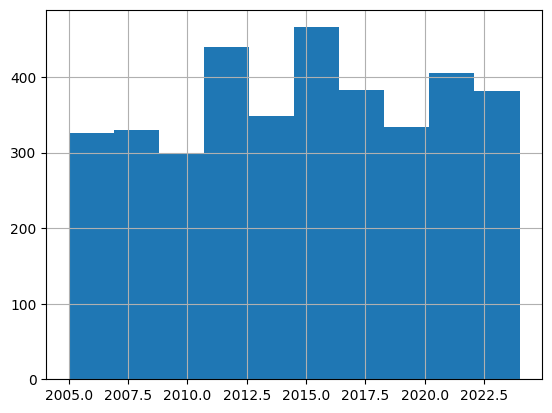

In [1213]:
dfAuthors.Year.hist()

In [1215]:
dfAuthors = pd.merge(dfAuthors, gdf[["Alpha-3", "Country"]], on="Alpha-3", how="left")

In [ ]:
for year in sorted(dfMain.Year.unique()):
    with open(f"./data-proceedings-md/dl-proceedings-{year}.md", "w") as f:
        f.write(f"# MobileHCI  {year}\n")
        dfMainYear = dfMain[dfMain.Year == year]
        for i, e in dfMainYear.iterrows():
            f.write(f"## {e.Title}\n")
            f.write(f"### Meta-Data\n")
            f.write(f"* Type: {e.Type}\n")
            f.write(f"* Session: {e.Section}\n")
            f.write(f"* DOI: {e.Doi}\n")

            f.write(f"### Authors\n")
            for j, author in dfAuthors[(dfAuthors.Doi == e.Doi)].iterrows():
                f.write(f"* {author.Name} = {author.Affiliation} = {author["Alpha-3"]} = {author["Url"]}\n")
            f.write(f"\n")

In [124]:
sorted(dfMain.Year.unique())

[2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024]